In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt') # https://www.nltk.org/api/nltk.tokenize.punkt.html
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform, pdist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import gensim
import logging
logging.basicConfig(format='(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

/var/folders/w_/b7x2zh4x4lqfb61j6dx3c11r0000gn/T/ipykernel_95865/1747332106.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nakatayuki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Import Data

In [2]:
train_df = pd.read_csv(f'data/train.csv')
test_df = pd.read_csv(f'data/test.csv')
sample_submit_df = pd.read_csv(f'data/sample_submit.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/pj_機械学習/SIGNATE/中田/医学論文の自動仕分けチャレンジ/data/train.csv'

In [ ]:
test_df.head()

,id,title,abstract
0,27145,Estimating the potential effects of COVID-19 p...,The objective of the paper is to analyse chang...
1,27146,Leukoerythroblastic reaction in a patient with...,NaN
2,27147,[15O]-water PET and intraoperative brain mappi...,[15O]-water PET was performed on 12 patients w...
3,27148,Adaptive image segmentation for robust measure...,We present a method that significantly improve...
4,27149,Comparison of Epidemiological Variations in CO...,The objective of this study is to compare the ...


## Preprocess the text data
NLTKパッケージを使用して、ストップワードを除去し、すべてのテキストを小文字に変換し、句読点を除去することにより、テキストデータを前処理する。


**ストップワードとは**

自然言語処理においては、出現頻度が高いにも関わらず特別な意味をもたない不要な単語を削除する必要があります。

この不要な語をストップワードと言います。

日本語で言えば、「は」、「です」、「する」などがストップワードに相当します。

英語で言えば「i」, 「a」, 「is」などがストップワードに相当します。

### **Stemmerとは**

違うwordや文法でも同じ意味として捉えられる文章や表現の揺れを統一させる方法。

ex)
たとえば、以下のコードでは、`word_list`の単語が異なる活用形だが、語幹のconnectに変換されている。

```
>>> porter = PorterStemmer()
>>> word_list = ["connected", "connecting", "connection", "connections"]
>>>
>>> for word in word_list:
...     print(porter.stem(word))
...
connect
connect
connect
connect
```

参考：
https://www.guru99.com/ja/stemming-lemmatization-python-nltk.html


### Tokenization

このコードはTfvectorizerによってTokenizatoinを行なっている。

tokenizationについてはこちらを参照
https://neptune.ai/blog/tokenization-in-nlp

概要：
文章は非構造データでコンピューターで計算するには向いていない形式なので、非構造 -> 構造化（数値化）できる状態にして、文章を文節や単語などの意味ある区切りで分けてベクトル化できるようにする。

tfとidf

__tf__

Term Frequencyで、単語の出現頻度です、文書$d_j$
における単語$w_i$
のtfは

$$
tf_{w_i, d_j} = \frac{w_iの出現数}{d_jの単語数}
$$

です、文書群が決まっているとき、tfは文書と単語を指定して初めて計算できます、

「文書中により高頻度で出現する単語ほど、その文書にとって重要だ」という考えです、

__idf__

Inverse Document Frequencyで、逆文書頻度です、idfの計算方法は、+1するなどのケアによって複数存在しますが、`TfidfVectorizer`で使われているものを紹介します、文書群における単語wi
のidfは

$$
idf_{w_i} = \log \frac{文書数 + 1}{w_iが出現する文書数 + 1} + 1
$$

です、文書群が決まっているとき、idfは単語さえ決めれば計算できます、

「特定の文書に出現する単語ほど、ある話題に特化した意味のある単語である」という考えです、

tf-idf
tf-idfは、上記2つの値の積で表されます、

In [ ]:
"""
特定の記号を空白に置換し、英数字以外を除去して小文字に統一するためのテキストクリーニング関数
"""
def clean_text(text):
    list_of_cleaning_signs = ['\x0c', '\n']
    for sign in list_of_cleaning_signs:
        text = text.replace(sign, ' ')

    # `re.sub()` では
    # 第一引数に正規表現パターン、
    # 第二引数に置換先文字列、
    # 第三引数に処理対象の文字列を指定する。
    clean_text = re.sub('[^a-zA-Z]+', ' ', text)
    return clean_text.lower()

"""
文にトークン化し、さらに単語にトークン化して、
英字のみをフィルタし、それぞれの単語を基本形に変換する

re.searchの利用例：

```
s = 'aaa@xxx.com bbb@yyy.net ccc@zzz.org'

print(re.search(r'[a-z]+@[a-z]+\.net', s))
# <re.Match object; span=(12, 23), match='bbb@yyy.net'>

print(re.search(r'[a-z]+@[a-z]+\.[a-z]+', s))
# <re.Match object; span=(0, 11), match='aaa@xxx.com'>
```

"""
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


"""
TF-IDFスコアが高い上位N個の特徴を選択する
"""
def top_tfidf_feats(row, terms, top_n=25):
    top_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [terms[i] for i in top_ids]
    return top_feats


"""
テキストからTF-IDFによるキーワード抽出を行う。
ここでトークナイザーとしてステミング関数を使用
"""
def extract_tfidf_keywords(texts, top_n=25):
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.95, max_features=2000000,
        min_df=0.05, stop_words="english",
        use_idf=True, tokenizer=tokenize_and_stem,
        ngram_range=(1,3)
    )

    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
    terms = tfidf_vectorizer.get_feature_names_out()

    arr = []
    for i in range(0, tfidf_matrix.shape[0]):
        row = np.squeeze(tfidf_matrix[i].toarray())
        feats = top_tfidf_feats(row, terms, top_n)
        arr.append(feats)
    return arr

## Pre-Processing

In [ ]:
"""
    step one:
    extract keywords per paper from Papers Data
    text clean -> tokenize -> stem -> tfidf -> keywords.
"""
papers_data = train_df

papers_data['abstract'] = papers_data['abstract'].fillna('')

papers_data['Title_clean'] = papers_data['title'].apply(lambda x:clean_text(x))
papers_data['Abstract_clean'] = papers_data['abstract'].apply(lambda x:clean_text(x))



In [ ]:
abstract2kw = extract_tfidf_keywords(papers_data['Abstract_clean'], 20)
title2kw = extract_tfidf_keywords(papers_data['Title_clean'], 20)

terms:  ['alzheim' 'alzheim s' 'alzheim s diseas' 'amyloid' 'associ' 'brain'
 'case' 'clinic' 'coronavirus' 'cov' 'covid' 'covid pandem' 'diseas'
 'dure' 'imag' 'infect' 'pandem' 'patient' 's' 's diseas' 'sar' 'sar cov'
 'studi' 'use']


In [ ]:
tfidf_vectorizer = TfidfVectorizer(
        max_df=0.95, max_features=2000000,
        min_df=0.05, stop_words="english",
        use_idf=True, tokenizer=tokenize_and_stem,
        ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(papers_data['Abstract_clean'])
terms = tfidf_vectorizer.get_feature_names_out()

df_features = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

df_features


,abeta,abnorm,activ,acut,acut respiratori,acut respiratori syndrom,ad,addit,adult,affect,...,underw,unit,use,valu,virus,volum,week,work,year,year old
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.415562,0.0,0.000000,0.174329,0.0
1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.326519,0.0,0.0,0.000000,...,0.0,0.0,0.026883,0.049694,0.0,0.000000,0.0,0.111032,0.000000,0.0
2,0.0,0.124171,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
3,0.0,0.000000,0.060333,0.0,0.0,0.0,0.000000,0.0,0.0,0.071573,...,0.0,0.0,0.240917,0.074225,0.0,0.000000,0.0,0.082920,0.000000,0.0
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27140,0.0,0.000000,0.065750,0.0,0.0,0.0,0.000000,0.0,0.0,0.155999,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.090366,0.000000,0.0
27141,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.180368,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
27142,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.182286,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
27143,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.073530,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0


In [ ]:
"""
step two:
word2vec representation
"""

word2vec_model = gensim.models.Word2Vec(abstract2kw+title2kw, vector_size=100, window=5, workers=4)

In [ ]:
"""
step three:
average top-n keywords vectors and compute similarities

このコードは、論文の抽象要旨（abstract）とタイトル（title）から抽出したキーワードを用いて、各論文のベクトル表現（doc2vecs）を生成し、それらの間の類似度を計算しています。プロセスは以下のステップに分けられます：

1. キーワードベクトルの平均化:
  - 各論文について、抽象要旨とタイトルから抽出したキーワードリスト（abstract2kwとtitle2kw）があります。
  - それぞれのキーワードについて、gensimのWord2Vecモデル（word2vec_model）を使用して、単語の埋め込みベクトルを取得します。このモデルは、単語を多次元空間上のベクトルとして表現し、単語の意味的な類似性を捉えます。
  - キーワードがWord2Vecモデルの語彙に含まれている場合、そのベクトルを取得し、論文のベクトル表現を計算するために使用します。論文のベクトル表現は、抽象要旨とタイトルのキーワードベクトルの平均で表されます。
  - 初期ベクトル（vec）は、100次元のゼロベクトルで始まり、キーワードのベクトルが見つかるたびに加算されます。この例では、ベクトルの次元数が100であると仮定していますが、実際の次元数はWord2Vecモデルによって異なります。

2. 類似度の計算:
  - すべての論文についてベクトル表現を計算した後、scipyライブラリのpdist関数を使用して、論文間のコサイン類似度を計算します。pdist関数は、与えられたベクトルのペア間の距離（この場合は類似度の逆）を計算します。
  - squareform関数を使用して、pdistから得られる距離ベクトルを距離行列に変換します。この行列の各要素は、対応する論文ペア間の類似度を表します。
  - このコードの主な目的は、論文の内容を基にして類似した論文を特定することです。キーワードの意味的な情報を利用することで、論文のトピックや内容が似ている度合いを定量的に評価することができます。
"""

doc2vecs = []
for i in range(len(abstract2kw)):
    vec = np.zeros(100)  # ベクトルの初期化をNumPy配列で行う
    for word in abstract2kw[i]:
        if word in word2vec_model.wv.key_to_index:  # 単語がモデルの語彙に含まれているかチェック
            vec += word2vec_model.wv[word]  # 単語ベクトルを加算

    for word in title2kw[i]:
        if word in word2vec_model.wv.key_to_index:  # 単語がモデルの語彙に含まれているかチェック
            vec += word2vec_model.wv[word]  # 単語ベクトルを加算

    doc2vecs.append(vec / (len(abstract2kw[i]) + len(title2kw[i])))  # 平均ベクトルを計算してリストに追加

similarities = squareform(pdist(doc2vecs, 'cosine'))

In [ ]:
"""
    k-means clustering and wordcloud(it can combine topic-models
    to give somewhat more interesting visualizations)
"""

num_clusters = 10
km = KMeans(n_clusters=num_clusters)
km.fit(doc2vecs)
clusters = km.labels_.tolist()

papers = { "id": papers_data["id"], "title": papers_data["title"], "judgement": papers_data["judgement"], "clusters": clusters}
papers_df = pd.DataFrame(papers, index=[clusters], columns=["id", "title", "judgement", "clusters"])
papers_df["clusters"].value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    4456
2    3397
5    3215
6    3102
3    3074
9    3025
1    2462
4    2358
8    1337
7     719
Name: clusters, dtype: int64

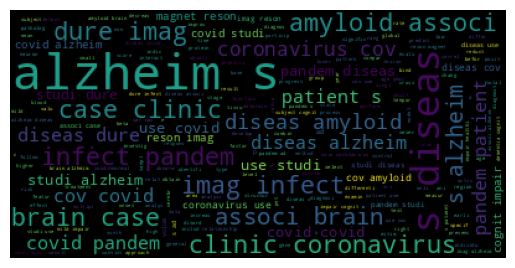

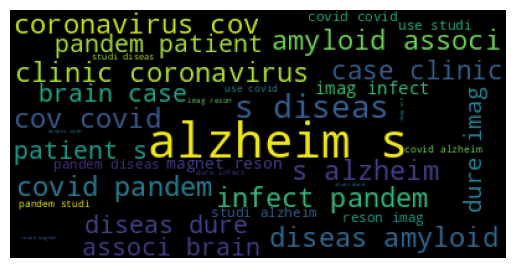

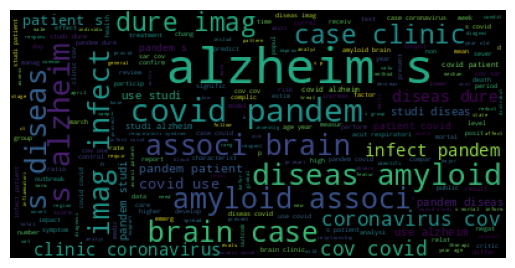

In [ ]:
def wordcloud_cluster_byIds(cluId):
    texts = []
    for i in range(0, len(clusters)):
        if clusters[i] == cluId:
            for word in abstract2kw[i]:
                texts.append(word)
            for word in title2kw[i]:
                texts.append(word)

    wordcloud = WordCloud(max_font_size=40, relative_scaling=.8).generate(' '.join(texts))
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.savefig(str(cluId)+".png")



wordcloud_cluster_byIds(2)
wordcloud_cluster_byIds(4)
wordcloud_cluster_byIds(9)


In [ ]:
import numpy as np

def document_vector(word2vec_model, doc):
    # ドキュメント内の単語ベクトルの平均を計算する（Gensim 4.0.0対応版）
    words = [word for word in doc if word in word2vec_model.wv.key_to_index]
    if len(words) == 0:
        return np.zeros(word2vec_model.vector_size)
    else:
        return np.mean(word2vec_model.wv[words], axis=0)

# 論文の抽象要旨と本文から特徴ベクトルを生成
features_abstract = np.array([document_vector(word2vec_model, doc) for doc in abstract2kw])
features_text = np.array([document_vector(word2vec_model, doc) for doc in title2kw])

# 特徴ベクトルを結合（例：平均を取る、または連結する）
features_combined = np.mean([features_abstract, features_text], axis=0)


In [ ]:
# 論文の抽象要旨と本文から特徴ベクトルを生成
features_abstract = np.array([document_vector(word2vec_model, doc) for doc in abstract2kw])
features_text = np.array([document_vector(word2vec_model, doc) for doc in title2kw])

# 特徴ベクトルを結合（例：平均を取る、または連結する）
features_combined = np.mean([features_abstract, features_text], axis=0)

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(features_combined, papers_data['judgement'], test_size=0.2, random_state=42)

# 分類モデル（例：ランダムフォレスト）の訓練
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# テストデータでの予測と評価
predictions = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))


Accuracy: 0.9791858537483883


In [ ]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# KMeansクラスタリングを実施
num_clusters = 2  # 診断精度研究に該当するか否かの2つのクラスタ
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(features_combined)

# クラスタIDを最も多い実際のラベルにマッピング
labels = np.zeros_like(clusters)
for i in range(num_clusters):
    mask = (clusters == i)
    labels[mask] = mode(papers_data['judgement'][mask])[0]

# Accuracyを計算
accuracy = accuracy_score(papers_data['judgement'], labels)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy: 0.9767176275557193


## test_dfの分類

In [ ]:
# テストデータセットの前処理
test_df['abstract'] = test_df['abstract'].fillna('')
test_df['Title_clean'] = test_df['title'].apply(lambda x: clean_text(x))
test_df['Abstract_clean'] = test_df['abstract'].apply(lambda x: clean_text(x))

# TF-IDFとWord2Vecを使用してキーワード抽出
abstract2kw_test = extract_tfidf_keywords(test_df['Abstract_clean'], 20)
title2kw_test = extract_tfidf_keywords(test_df['Title_clean'], 20)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev'

tfidf_matrix:    (0, 259)	0.11564846837725548
  (0, 247)	0.11414535940228777
  (0, 258)	0.10294442244515278
  (0, 66)	0.08711027611865224
  (0, 213)	0.12026779955852257
  (0, 64)	0.13155889267902177
  (0, 158)	0.1173523713164052
  (0, 129)	0.08962600192800625
  (0, 161)	0.12010371538216
  (0, 238)	0.1360383521455343
  (0, 119)	0.10103149211808862
  (0, 237)	0.1099414218238691
  (0, 231)	0.12581169664590766
  (0, 154)	0.12622495446062448
  (0, 125)	0.09870016190308949
  (0, 141)	0.08288924960175696
  (0, 105)	0.12534371266596125
  (0, 211)	0.24481957515160171
  (0, 305)	0.09662023238063108
  (0, 106)	0.10618300200461504
  (0, 160)	0.1327210618647515
  (0, 90)	0.09609775133066488
  (0, 32)	0.09728208925640502
  (0, 18)	0.1909462130136042
  (0, 178)	0.10476681550590135
  :	:
  (40833, 114)	0.04504784901326641
  (40833, 224)	0.20760587075561365
  (40833, 98)	0.15144747054666063
  (40833, 112)	0.12635602630993115
  (40833, 48)	0.035103440050059345
  (40833, 165)	0.05991863675474707
  (40833

In [ ]:
doc2vecs_test = []
for i in range(len(abstract2kw_test)):
    vec = np.zeros(100)  # ベクトルの初期化
    for word in abstract2kw_test[i]:
        if word in word2vec_model.wv.key_to_index:
            vec += word2vec_model.wv[word]
    for word in title2kw_test[i]:
        if word in word2vec_model.wv.key_to_index:
            vec += word2vec_model.wv[word]
    doc2vecs_test.append(vec / (len(abstract2kw_test[i]) + len(title2kw_test[i])))

similarities = squareform(pdist(doc2vecs, 'cosine'))

In [ ]:
# KMeansクラスタリングの適用
clusters_test = km.predict(doc2vecs_test)

# クラスタリング結果の変換（クラスタIDを1 or 0にマッピング）
# この例では、クラスタ0をjudgement=1に、クラスタ1をjudgement=0にマッピングします
# 実際には、訓練データに基づいて適切なマッピングを行う必要があります
judgements_test = [0 if cluster == 0 else 1 for cluster in clusters_test]

# 結果のDataFrameの作成
results_df = pd.DataFrame({
    'id': test_df['id'],
    'judgement': judgements_test
})

# CSVファイルに保存
results_df.to_csv('test_judgements.csv', index=False)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


## LightGBM


In [ ]:
import lightgbm as lgb

# 特徴量ベクトルとラベルを用意
X = np.array(doc2vecs)  # 特徴量ベクトル, doc2vecs は数値のリストのリスト
y = np.array(papers_data['judgement'])  # 正解ラベル

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBMデータセットの作成
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

# パラメータの設定
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# モデルの訓練
gbm = lgb.train(params,
                train_data,
                valid_sets=[valid_data],  # 修正: 検証セットをリストとして渡す
                num_boost_round=100)  # 修正: early_stopping_roundsを適切に使用

# テストデータの予測
y_pred = gbm.predict(doc2vecs_test, num_iteration=gbm.best_iteration)

# 予測結果を二値に変換
y_pred_binary = [1 if prob > 0.5 else 0 for prob in y_pred]
